In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import PassManager

service = QiskitRuntimeService()

In [2]:
def get_ghz_circ_static(num_qubit):
    if num_qubit%2==1:                                                     #odd no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-1)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-1):
            qc.cx(i,i+1)
            qc.cx(num_qubit-i-1,num_qubit-i-2)
        

    else:                                                                    #even no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-2)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-2):
            qc.cx(i,i+1)
            qc.cx(num_qubit-1-i-1,num_qubit-i-3)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc

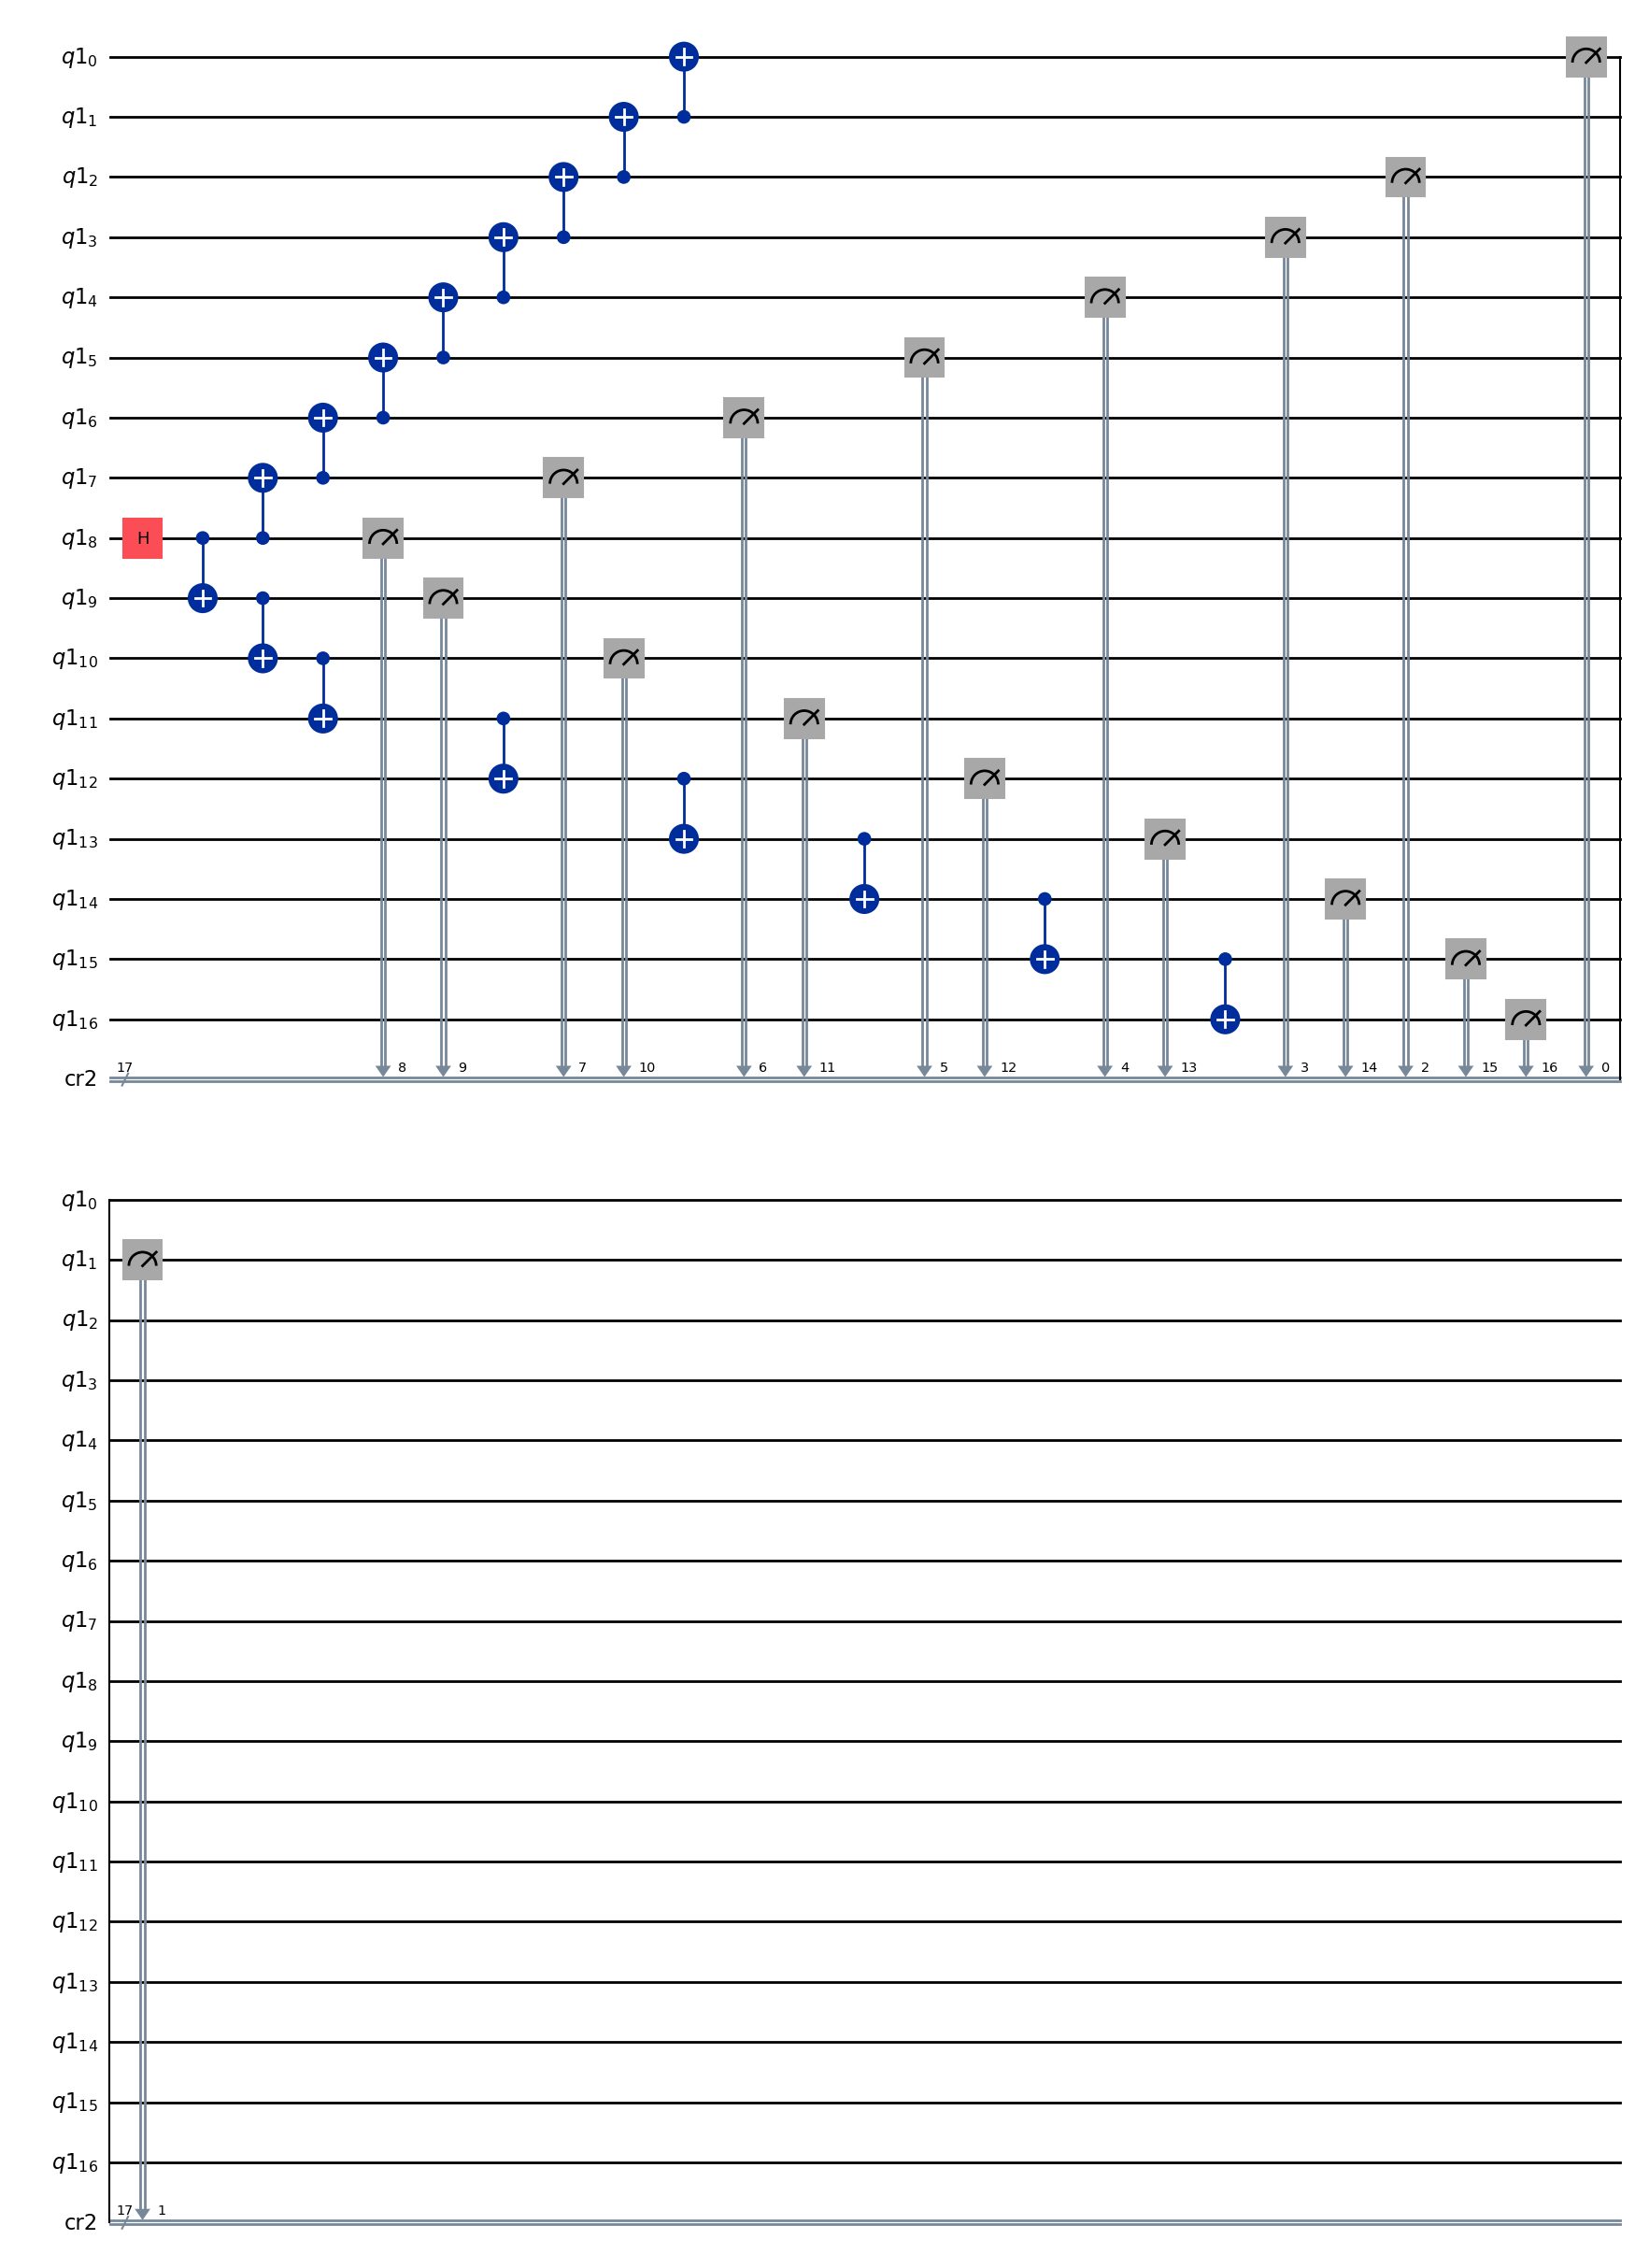

In [3]:
qc = get_ghz_circ_static(num_qubit=17)
qc.draw("mpl")

In [4]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager



real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)

pm_modified = generate_preset_pass_manager(backend=aer, optimization_level=2, init_method="qubit_reuse_1")
pm = generate_preset_pass_manager(backend=aer, optimization_level=2, init_method="qubit_reuse")
transpiled_qc_modified = pm_modified.run(qc)
transpiled_qc = pm.run(qc)


classical registers are [ClassicalRegister(17, 'cr2')]
classical registers are [ClassicalRegister(17, 'cr2')]


In [5]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def get_ghz_circ_dynamic_2(num_qubit):
    qc=get_ghz_circ_static(num_qubit)
    aer_sim = AerSimulator()
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=2, init_method="qubit_reuse")
    pm_modified = generate_preset_pass_manager(backend=aer_sim, optimization_level=2, init_method="qubit_reuse_1")
    transpiled_qc = pm.run(qc)
    transpiled_qc_modified = pm_modified.run(qc)
    
    return transpiled_qc, transpiled_qc_modified

In [6]:
min_qubit=17
max_num_qubit=17
copies=2

#qc_list_dynamic_1=[]
#qc_list_dynamic_2=[]
#qc_list_static=[]
#observables=[]

qc_list=[]
num_qubit_list=list(range(min_qubit,max_num_qubit+1))
for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_ghz_circ_static(num_qubit))               # no reuse
        #qc_list.append(get_ghz_circ_dynamic_1(num_qubit))
        qc_list.append(get_ghz_circ_dynamic_2(num_qubit)[0])          # normal reuse
        qc_list.append(get_ghz_circ_dynamic_2(num_qubit)[1])         # modified reuse
print(num_qubit_list)

classical registers are [ClassicalRegister(17, 'cr2')]
classical registers are [ClassicalRegister(17, 'cr2')]
classical registers are [ClassicalRegister(17, 'cr2')]
classical registers are [ClassicalRegister(17, 'cr2')]
classical registers are [ClassicalRegister(17, 'cr2')]
classical registers are [ClassicalRegister(17, 'cr2')]
classical registers are [ClassicalRegister(17, 'cr2')]
classical registers are [ClassicalRegister(17, 'cr2')]
[17]


classical registers are [ClassicalRegister(10, 'cr2')]
classical registers are [ClassicalRegister(10, 'cr2')]


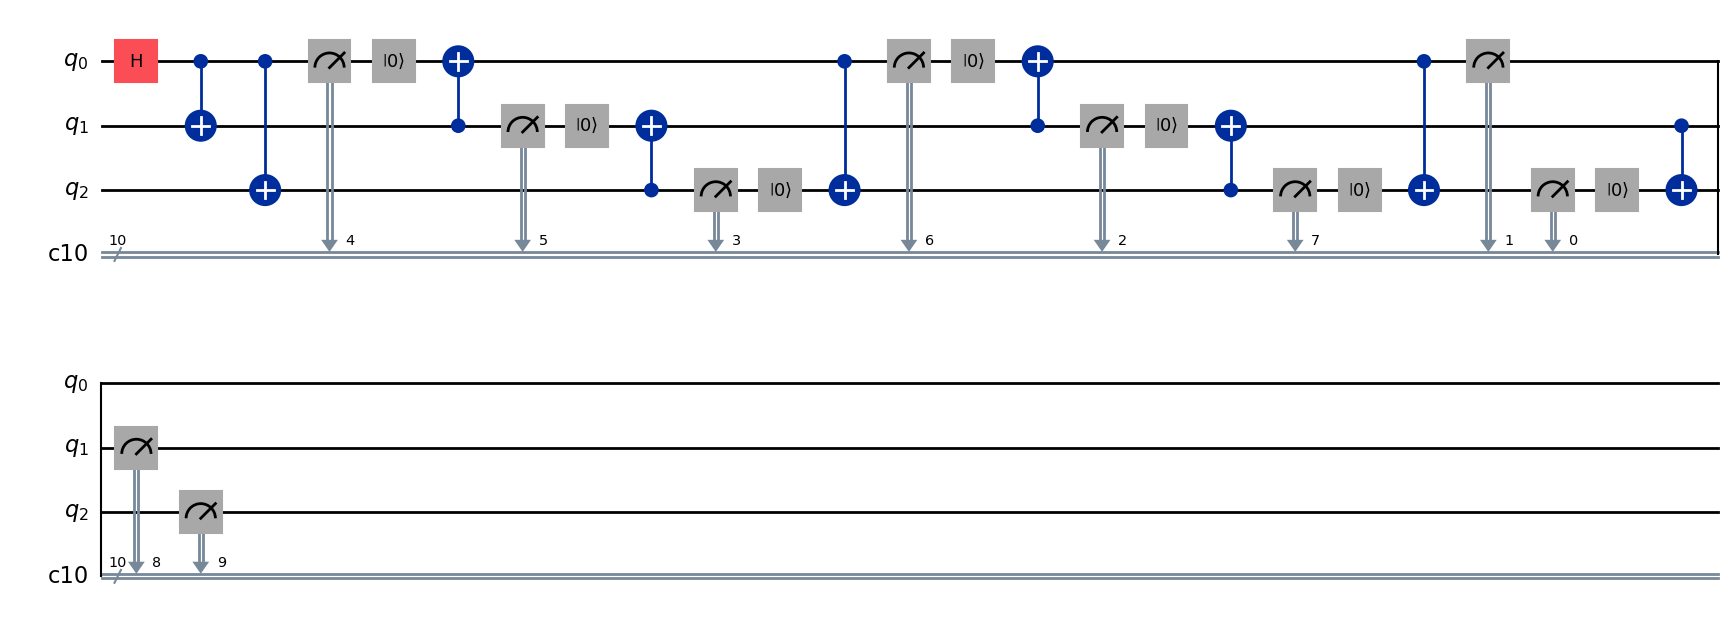

In [21]:
get_ghz_circ_dynamic_2(10)[0].draw("mpl",idle_wires=False)

classical registers are [ClassicalRegister(10, 'cr2')]
classical registers are [ClassicalRegister(10, 'cr2')]


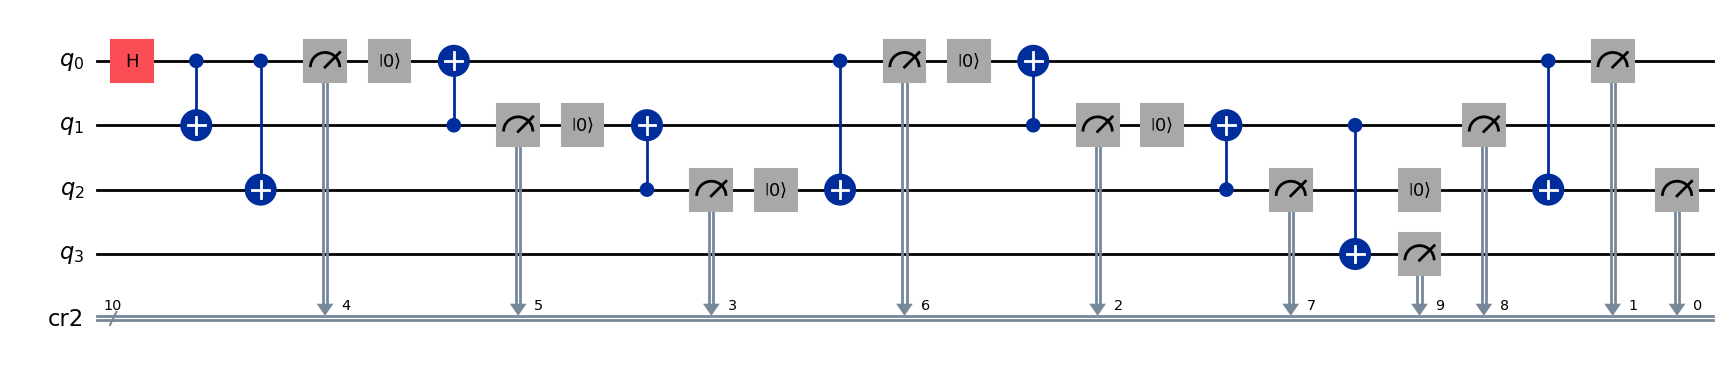

In [22]:
get_ghz_circ_dynamic_2(10)[1].draw("mpl",idle_wires=False)

In [7]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=2)
qc_transpiled_list=[]

qc_transpiled_list_ideal = pm.run(qc_list)

In [8]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [9]:
print(result_ideal)
len(result_ideal)

PrimitiveResult([PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>)))], metadata={})


6

In [10]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
k=1
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_ideal[(3*i*copies)+(3*j)].data    
        data_dynamic_1 = result_ideal[(3*i*copies)+((3*j)+1)].data 
        data_dynamic_2 = result_ideal[(3*i*copies)+((3*j)+2)].data

        print(data_static)
        print(data_dynamic_1)
        print(data_dynamic_2)
        
        counts_static=data_static.cr2.get_counts()
        #counts_dynamic_1=data_dynamic_1.cr2.get_counts()     # normal reuse
        counts_dynamic_2=data_dynamic_2.cr2.get_counts()      # modified reuse
        
        # Replacing 'cr2' with the appropriate attribute if needed
        dynamic_1_attr_name = f'c{4*k-2}'
        if hasattr(data_dynamic_1, dynamic_1_attr_name):
            counts_dynamic_1 = getattr(data_dynamic_1, dynamic_1_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_1_attr_name} not found in data_dynamic_1")
        
        counts_list_ideal.append(counts_static)
        counts_list_ideal.append(counts_dynamic_1)
        counts_list_ideal.append(counts_dynamic_2)
        k=k+1

DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))


In [11]:
# noisy simulation circuit list
service = QiskitRuntimeService()
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)
pm = generate_preset_pass_manager(optimization_level=2, backend=aer)
qc_transpiled_list = pm.run(qc_list)

In [12]:
sampler = Sampler(backend=aer)
result_real = sampler.run(qc_transpiled_list).result()

In [13]:
print(result_real)
len(result_real)

PrimitiveResult([PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>)))], metadata={})


6

In [14]:
# For getting list of noisy simulation counts (argument required for Fidelity)
counts_list_real=[]
k=1
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_real[(3*i*copies)+(3*j)].data    
        data_dynamic_1 = result_real[(3*i*copies)+((3*j)+1)].data 
        data_dynamic_2 = result_real[(3*i*copies)+((3*j)+2)].data

        print(data_static)
        print(data_dynamic_1)
        print(data_dynamic_2)
        
        counts_static=data_static.cr2.get_counts()
        #counts_dynamic_1=data_dynamic_1.cr2.get_counts()     # normal reuse
        counts_dynamic_2=data_dynamic_2.cr2.get_counts()      # modified reuse
        
        # Replacing 'cr2' with the appropriate attribute if needed
        dynamic_1_attr_name = f'c{4*k-2}'
        if hasattr(data_dynamic_1, dynamic_1_attr_name):
            counts_dynamic_1 = getattr(data_dynamic_1, dynamic_1_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_1_attr_name} not found in data_dynamic_1")
        
        counts_list_real.append(counts_static)
        counts_list_real.append(counts_dynamic_1)
        counts_list_real.append(counts_dynamic_2)
        k=k+1

DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))


In [15]:
#Calculation of lists of Fidelity mean and std deviation of real hardware simulation in ibm_sherbrooke
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
 
Fidelity_mean_static_sherbrooke=[]
Fidelity_mean_dynamic_1_sherbrooke=[]
Fidelity_mean_dynamic_2_sherbrooke=[]

Fidelity_std_static_sherbrooke=[]
Fidelity_std_dynamic_1_sherbrooke=[]
Fidelity_std_dynamic_2_sherbrooke=[]

Fidelity_copies_static_sherbrooke=[]
Fidelity_copies_dynamic_1_sherbrooke=[]
Fidelity_copies_dynamic_2_sherbrooke=[]

for i in range(len(num_qubit_list)):
    
    for j in range(copies):
        
        Fidelity_static= hellinger_fidelity(counts_list_ideal[(3*i*copies)+(3*j)], counts_list_real[(3*i*copies)+(3*j)])
        Fidelity_dynamic_1=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+1)], counts_list_real[(3*i*copies)+((3*j)+1)])
        Fidelity_dynamic_2=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+2)], counts_list_real[(3*i*copies)+((3*j)+2)])
        
        Fidelity_copies_static_sherbrooke.append(Fidelity_static)
        Fidelity_copies_dynamic_1_sherbrooke.append(Fidelity_dynamic_1)
        Fidelity_copies_dynamic_2_sherbrooke.append(Fidelity_dynamic_2)

    
    Fidelity_mean_static_sherbrooke.append(statistics.mean(Fidelity_copies_static_sherbrooke))
    Fidelity_mean_dynamic_1_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_1_sherbrooke))
    Fidelity_mean_dynamic_2_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_2_sherbrooke))
    
    Fidelity_std_static_sherbrooke.append(statistics.stdev(Fidelity_copies_static_sherbrooke))
    Fidelity_std_dynamic_1_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_1_sherbrooke))
    Fidelity_std_dynamic_2_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_2_sherbrooke))
    
    Fidelity_copies_static_sherbrooke.clear()
    Fidelity_copies_dynamic_1_sherbrooke.clear()
    Fidelity_copies_dynamic_2_sherbrooke.clear()

[0.6649994269494153]
[0.7032393918927913]
[0.6321824791421125]
[0.04004987974028379]
[0.7032393918927913]
[0.04750593142392858]


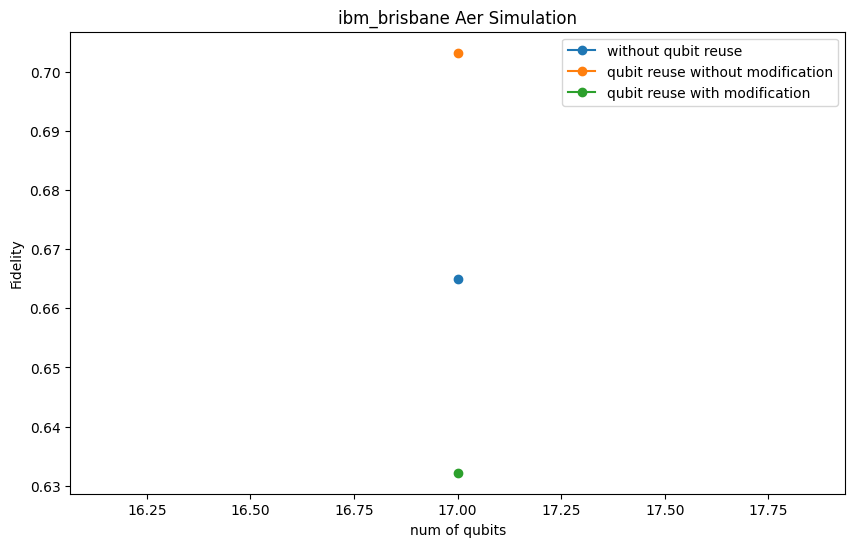

In [20]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))

# Create  data.
ax1.set_xlabel('num of qubits')
ax1.set_ylabel('Fidelity')
ax1.set_title('ibm_brisbane Aer Simulation')

x1 = num_qubit_list
y1_static = Fidelity_mean_static_sherbrooke
y1_dynamic_1 = Fidelity_mean_dynamic_1_sherbrooke
y1_dynamic_2 = Fidelity_mean_dynamic_2_sherbrooke
print(y1_static)
print(y1_dynamic_1)
print(y1_dynamic_2)

y_error_static =Fidelity_std_static_sherbrooke
y_error_dynamic_1 =Fidelity_std_dynamic_1_sherbrooke
y_error_dynamic_2 =Fidelity_std_dynamic_2_sherbrooke
print(y_error_static)
print(y1_dynamic_1)
print(y_error_dynamic_2)

ax1.plot(x1, y1_static, 'o-',label='without qubit reuse')
ax1.plot(x1, y1_dynamic_1, 'o-',label='qubit reuse without modification')
ax1.plot(x1, y1_dynamic_2, 'o-',label='qubit reuse with modification')
"""
ax1.errorbar(x1, y1_static,
			yerr = y_error_static, label='without qubit reuse error bar',
			fmt ='o')
ax1.errorbar(x1, y1_dynamic_1,
			yerr = y_error_dynamic_1, label='qubit reuse without modification error bar',
			fmt ='o')
ax1.errorbar(x1, y1_dynamic_2,
			yerr = y_error_dynamic_2, label='qubit reuse with modification error bar',
			fmt ='o')
"""
plt.legend()
plt.show()